In [1]:
### This noteboook is used for dealing with problem in ContiguousSNP
import sys
import os

## import function from python_scripts
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from python_scripts.gene_level_MoM import * 
from python_scripts.pairwise_product_var_calculation import * 
from python_scripts.visualization import * 
from python_scripts.weight_function import * 

In [5]:
###unzip file
zip_files = [
    "../test_data/chr1_Contiguous1KSNP.zip",
    "../test_data/chr1_Random1KSNP.zip"
]
for zf in zip_files:
    with zipfile.ZipFile(zf, "r") as z:
        z.extractall("test_data")   
    print(f"Unzipped: {zf}")
##read data  
##Random snp
RandomSNP = pd.read_csv("test_data/chr1_Random1KSNP.raw", sep=r'\s+')
RandomSNP = RandomSNP.iloc[:, 6:].to_numpy()
##Contiguous snp
ContiguousSNP = pd.read_csv("test_data/chr1_Contiguous1KSNP.raw", sep=r'\s+')
ContiguousSNP = ContiguousSNP.iloc[:, 6:].to_numpy()

In [15]:
### experiment1: can we use pi pj and cov_sigma ij  to represent pairwise product variance (var zizj).
### we simulate two SNP with AF pi pj and their cov sigmaij, if the formula apply to these, they should apply to all SNPs in real data

# the parameter
n = 2
p1 = 0.3
p2 = 0.4
sigmaij = 0.2
c = sigmaij / n  
p11 = p1 * p2 + c
p10 = p1 - p11
p01 = p2 - p11
p00 = 1 - p11 - p10 - p01

sizes = [1000,10000,100000,1000000,10000000]

for size in sizes:
     ### simulate two SNPs
     probs = np.array([p00, p01, p10, p11])
     codes = np.random.choice(4, size=(size, n), p=probs)
     
     X1 = ((codes == 2) | (codes == 3)).sum(axis=1)
     X2 = ((codes == 1) | (codes == 3)).sum(axis=1)
     X = np.column_stack((X1, X2))
     Z = (X - X.mean(axis=0)) / X.std(axis=0)
     var_zizj_formule= calculate_varZiZj(X)[0]
     empirical_var_zizj= np.var(Z[:,0]*Z[:,1])

     ### compare their result
     print(" ")
     print(f"Under the size of individual:{size}")
     print(f"The var(zizj) given by formule:{var_zizj_formule}")
     print(f"The empirical var(zizj):{empirical_var_zizj}")
     print(f"The relative error:{(var_zizj_formule - empirical_var_zizj) / empirical_var_zizj:.6f}")

print(" ")
print("With the increase of individual size, the var(zizj) given by formule will approach empirical var(zizj) ")

 
Under the size of individual:1000
The var(zizj) given by formule:1.0635172210204191
The empirical var(zizj):1.1228495382033967
The relative error:-0.052841
 
Under the size of individual:10000
The var(zizj) given by formule:1.0811638531515486
The empirical var(zizj):1.0881182198260695
The relative error:-0.006391
 
Under the size of individual:100000
The var(zizj) given by formule:1.0819809436668566
The empirical var(zizj):1.0826055897383053
The relative error:-0.000577
 
Under the size of individual:1000000
The var(zizj) given by formule:1.0792589038240628
The empirical var(zizj):1.0789592871408817
The relative error:0.000278
 
Under the size of individual:10000000
The var(zizj) given by formule:1.0794602637192818
The empirical var(zizj):1.0793901320091852
The relative error:0.000065
 
With the increase of individual size, the var(zizj) given by formule will approach empirical var(zizj) 


In [16]:
### experiment2: check the distibution of pairwise product variance (var zizj) in Random and contiguous SNPs
RandomSNP_varZiZj= calculate_varZiZj(RandomSNP)
ContiguousSNP_varZiZj= calculate_varZiZj(ContiguousSNP)

------------------RandomSNP distribution-------------------


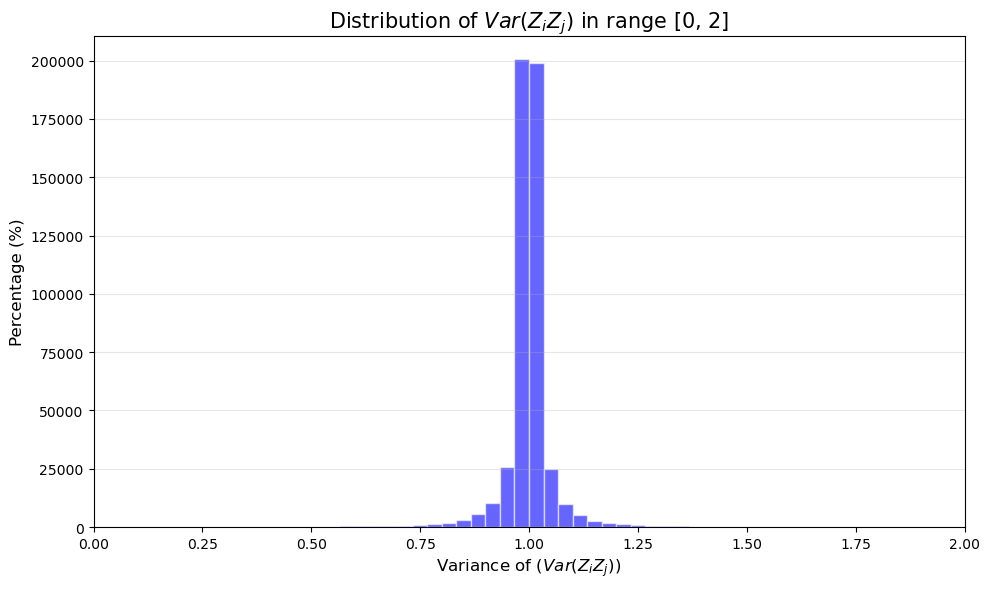

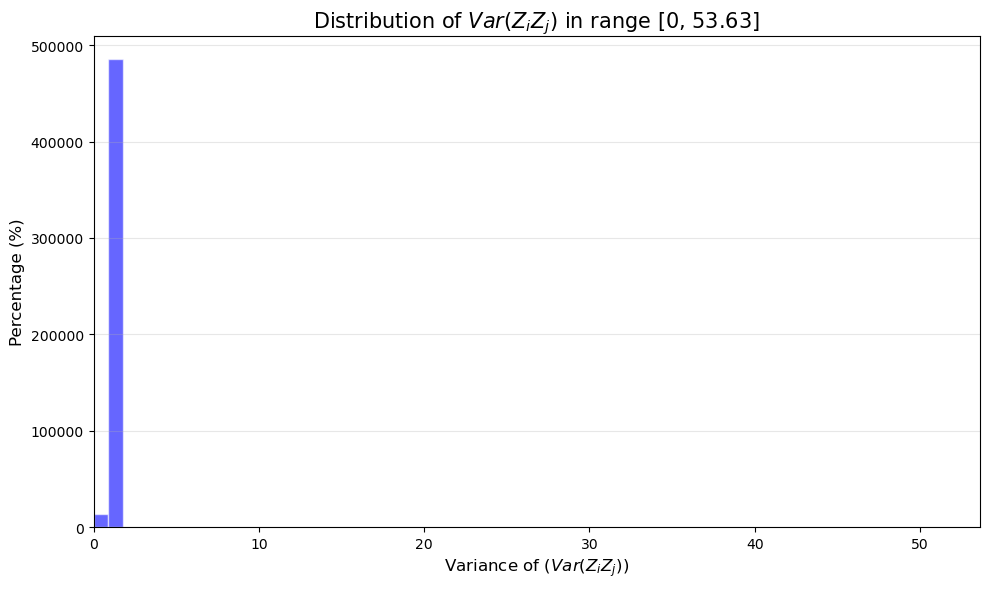

------------------ContiguousSNP distribution-------------------


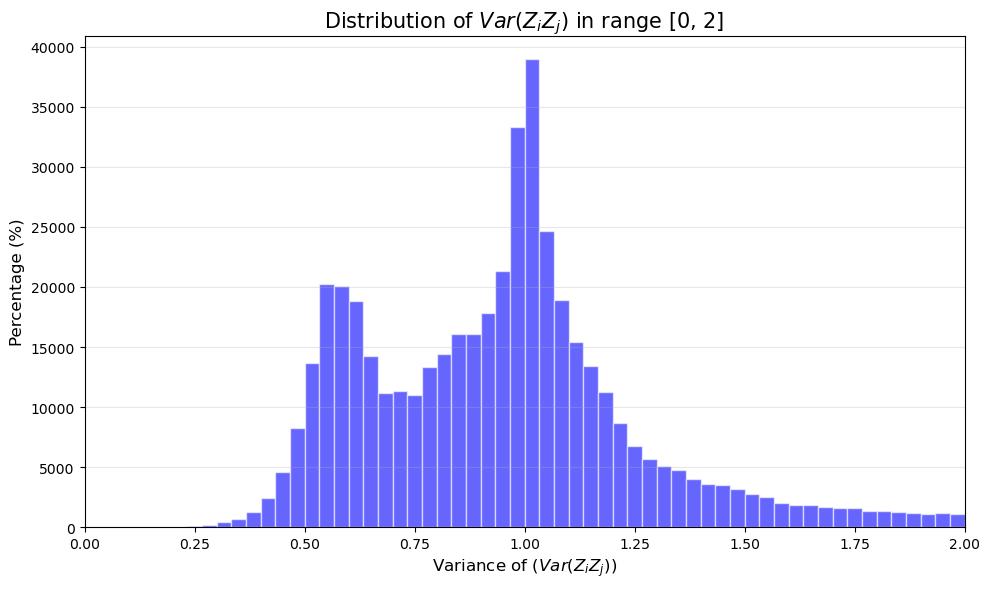

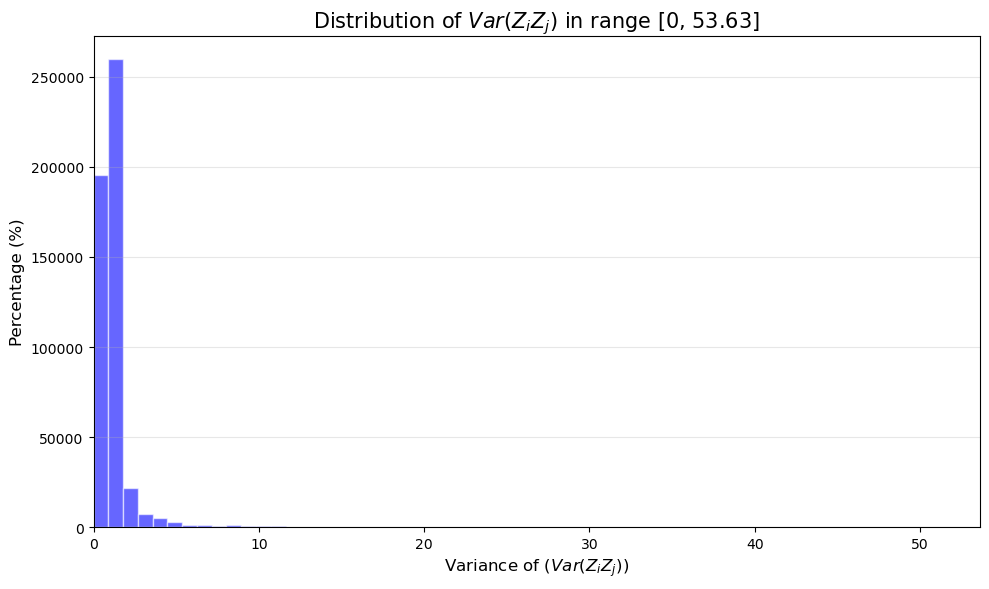

In [40]:
### draw the distribution
print("------------------RandomSNP distribution-------------------")
plot_distribution_varzizj(RandomSNP_varZiZj,0,2,60) ## pick variance with range 0 to 2 
plot_distribution_varzizj(RandomSNP_varZiZj,0,round(max(ContiguousSNP_varZiZj), 2),60)  ## draw the distriburion of all variance  
print("------------------ContiguousSNP distribution-------------------")
plot_distribution_varzizj(ContiguousSNP_varZiZj,0,2,60) ## pick variance with range 0 to 2 
plot_distribution_varzizj(ContiguousSNP_varZiZj,0,round(max(ContiguousSNP_varZiZj), 2),60) ## draw the distriburion of all variance